# Post-COVID Evaluation

In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *
from plotnine import *

In [2]:
df = load_predictions('post-covid')

In [3]:
# df.value = df.value.round()

In [4]:
# df = df[df.forecast_date != '2023-12-28']

In [5]:
model_names = {
    'KIT-MeanEnsemble' : 'Ensemble',
    'lightgbm2' : 'LightGBM',
    'tsmixer' : 'TSMixer',
    'KIT-hhh4' : 'hhh4'
}

In [6]:
model_colors = {
    "LightGBM": "#B30000",
    "TSMixer": "#E69F00",
    "KIT-frozen_baseline": "#999999",
    "KIT": "#56B4E9",
    "LMU": "#F0E442",
    "Ensemble": "#009E73",
    "MedianEnsemble": "#60D1B3",
    "RIVM": "#80471C",
    "hhh4": "#3C4AAD",
    "SU": "#CC79A7",
    "SZ": "#000000"
}

In [7]:
df.model = df.model.replace(model_names)

In [8]:
df = df[df.model != 'lightgbm']

# Compute scores

#### National level

In [9]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Ensemble,377.213995,172.441267,650.415435,1200.070698,0.317073,0.926829
1,LightGBM,389.173967,45.180977,830.436433,1264.791377,0.469512,0.914634
2,TSMixer,420.129774,289.905952,595.242153,1305.277879,0.353659,0.878049
3,hhh4,353.540941,434.439024,789.575784,1577.555749,0.250000,0.725610


In [10]:
# evaluate_models(df, 'national', by_horizon=True)

#### Age groups

In [11]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Ensemble,84.707510,46.903707,103.294556,234.905773,0.417683,0.909553
1,LightGBM,67.346171,30.987203,157.901964,256.235338,0.318089,0.768293
2,hhh4,103.873403,85.830285,94.195703,283.899390,0.486789,0.908537
3,TSMixer,88.294441,62.071067,140.293788,290.659297,0.340447,0.742886


In [12]:
# evaluate_models(df, 'age', by_horizon=True)

In [13]:
# evaluate_models(df, 'age', by_age=True)

# Plots

In [14]:
df_national = evaluate_models(df, 'national')
df_age = evaluate_models(df, 'age')

In [15]:
df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

In [16]:
df_long = pd.melt(df_wide, id_vars=['level', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [17]:
df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


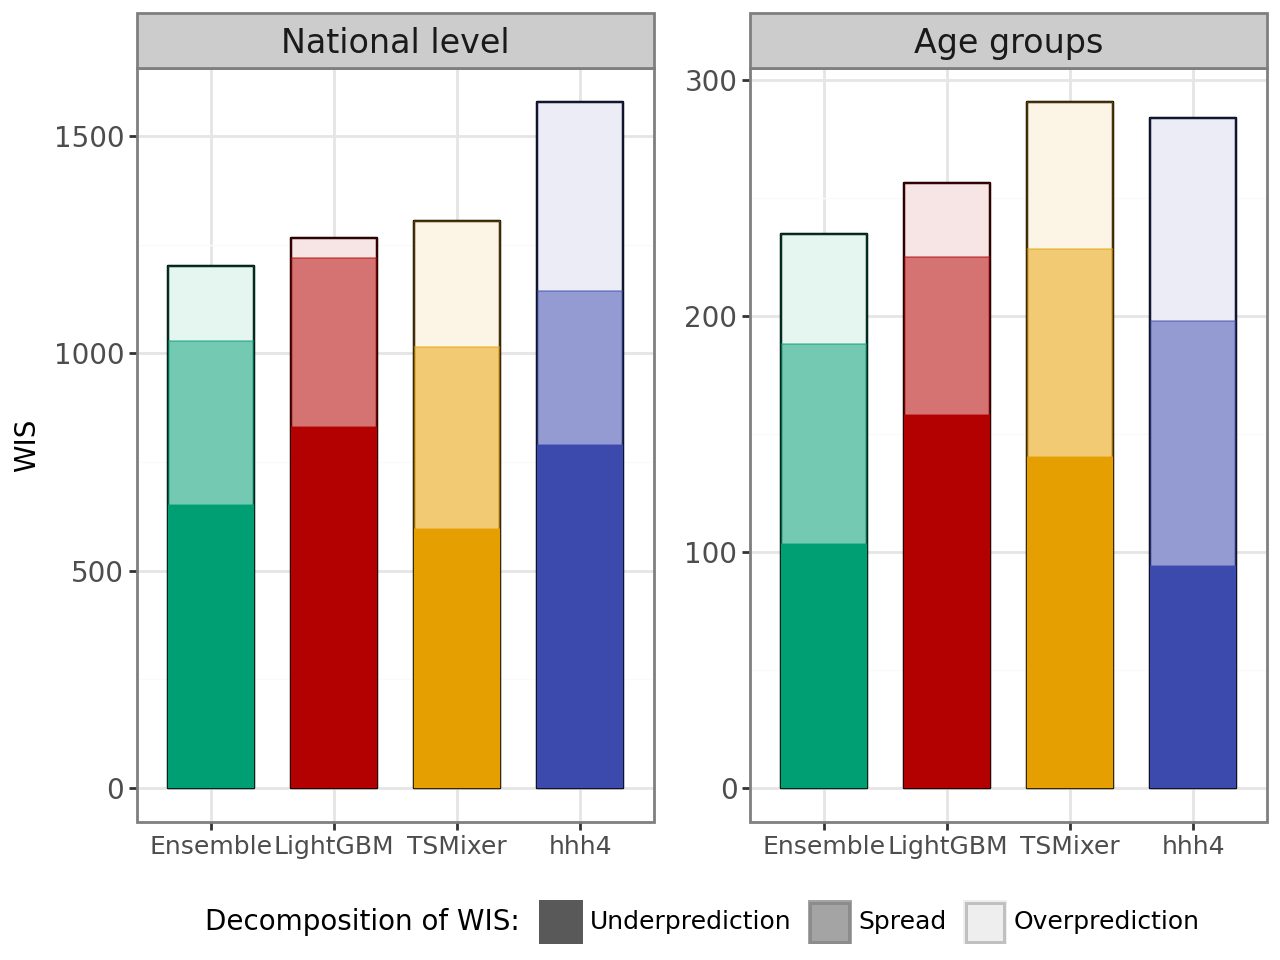

In [18]:
p = (ggplot()
    + facet_wrap('~level', nrow=1, scales='free_y', labeller=lambda x: ('National level' if x == 'national' else 'Age groups'))
    + geom_bar(df_long[df_long.metric == 'wis'], aes(x='model', y='value'), fill='white', color='black', stat='identity', width=0.7)
    + geom_bar(df_long[df_long.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric', color='model'), size=0.1, stat='identity', width=0.7, 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_color_manual(values=model_colors)
    + scale_fill_manual(values=model_colors)
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="")
    #+ coord_flip()
    + theme_bw()
    + theme(legend_position='bottom',
            legend_title_position='left',
            strip_text=element_text(size=12),             # Facet title text size
            legend_title=element_text(size=10),           # Legend title text size
            legend_text=element_text(size=9),             # Legend item text size
            axis_text_x=element_text(size=9),               # Axis text (tick labels) size
            axis_text_y=element_text(size=10),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14))              # Plot title text size)
   )
p

In [179]:
p.save("../figures/wis.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis.pdf


## By horizon

In [19]:
df_national = evaluate_models(df, 'national', by_horizon=True)
df_age = evaluate_models(df, 'age', by_horizon=True)

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_long = pd.melt(df_wide, id_vars=['level', 'horizon', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

In [20]:
def plot_scores_by_horizon_and_model(df, level='national'):
    scores = df[df.level==level].copy()
    
    desired_order = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_grid(cols='horizon', labeller=lambda x: 'Horizon: ' + str(x))  # Create a facet for each horizon
        # + facet_wrap('~horizon', nrow=4, labeller=lambda x: 'Horizon: ' + str(x))  # Create a facet for each horizon
        + theme_bw()
        + theme(legend_position='right',
            legend_title_position='top',
            strip_text=element_text(size=10),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14)              # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


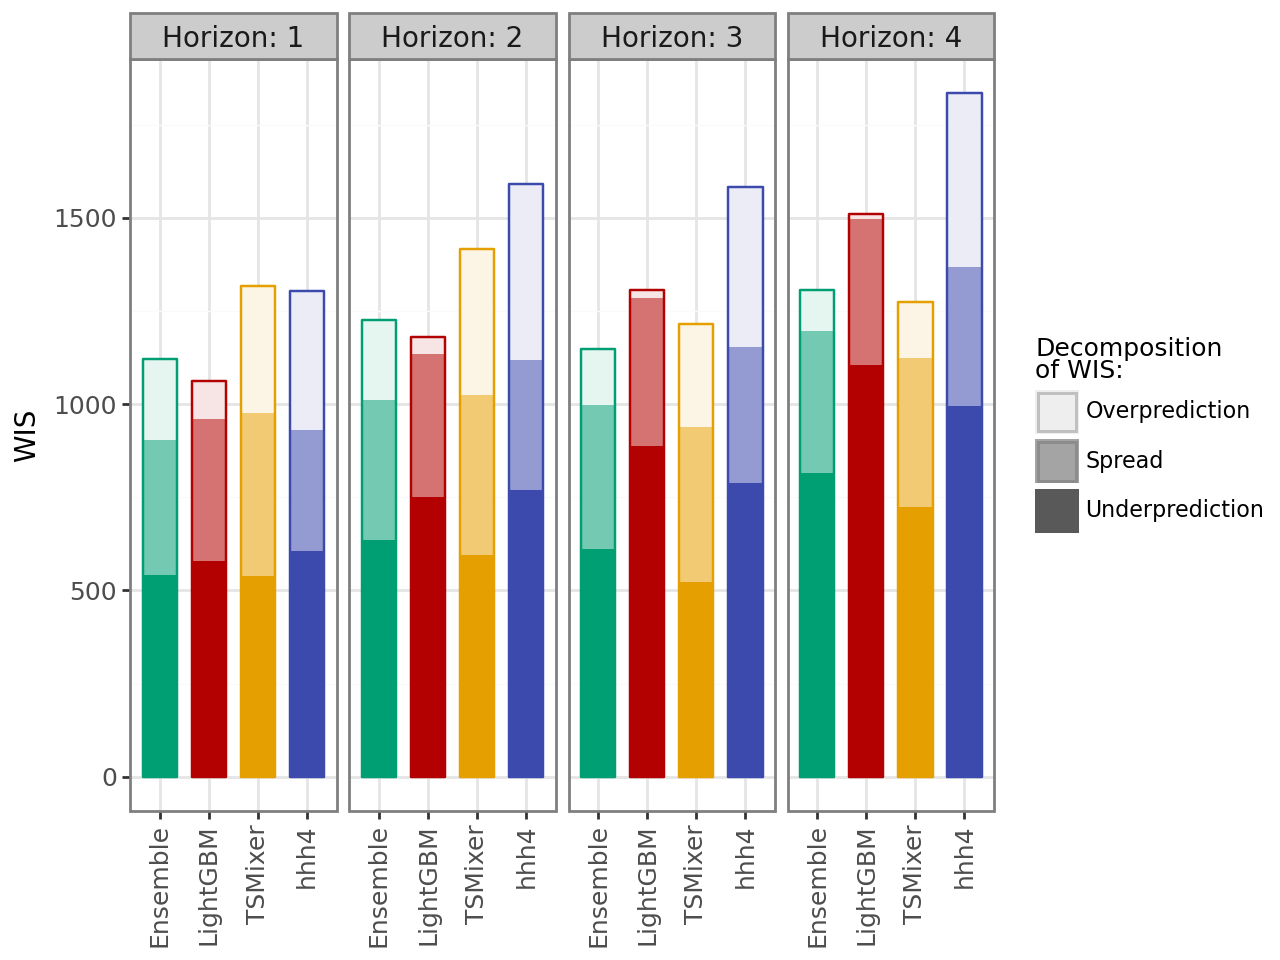

In [21]:
p = plot_scores_by_horizon_and_model(df_long, 'national')
p

In [139]:
p.save("../figures/wis_national_horizon.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_national_horizon.pdf


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


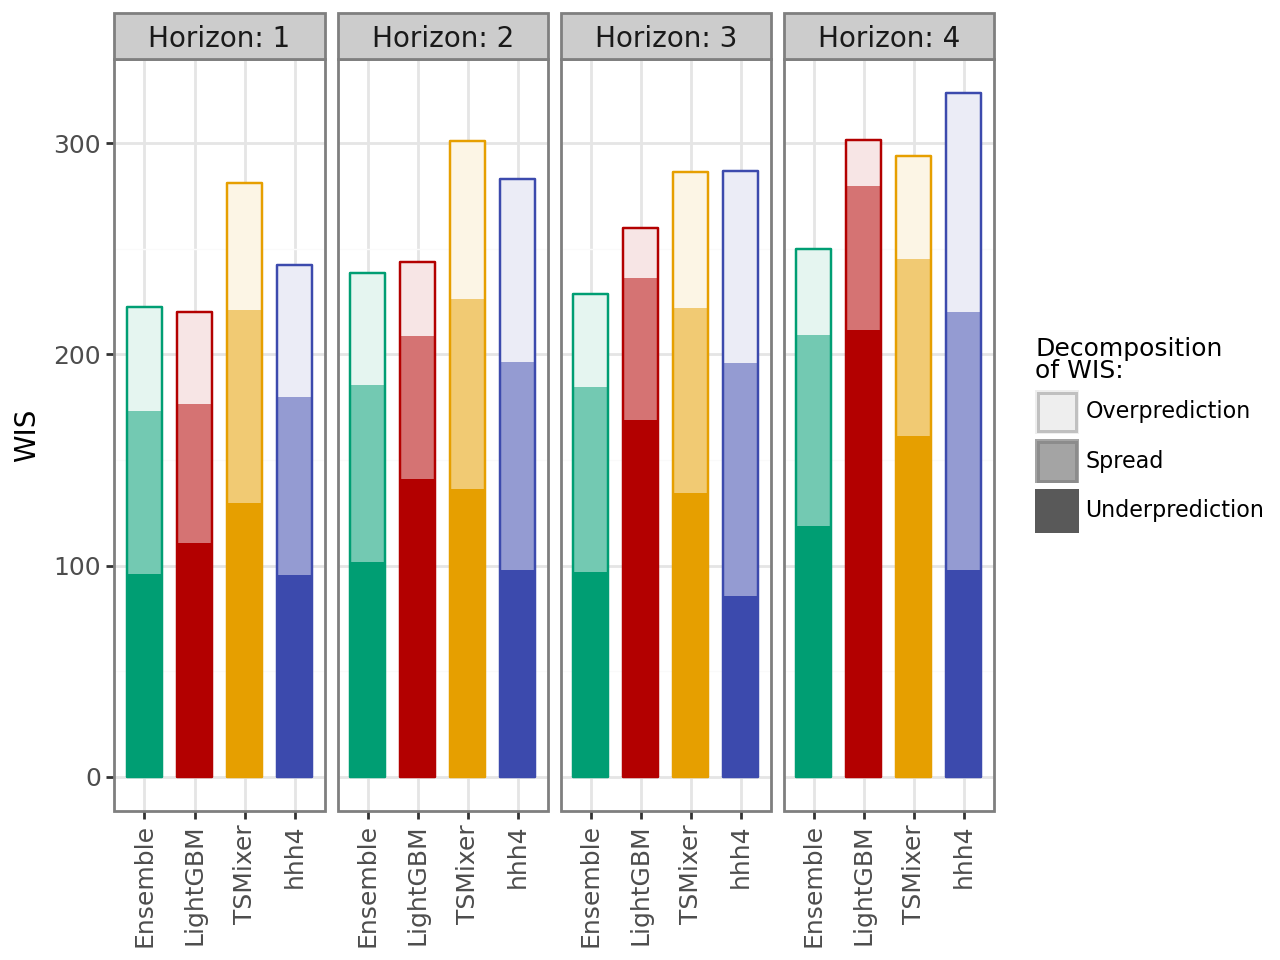

In [22]:
p = plot_scores_by_horizon_and_model(df_long, level='age')
p

In [141]:
p.save("../figures/wis_age_horizon.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age_horizon.pdf


## By age group

In [23]:
scores_age = evaluate_models(df, 'age', by_age=True)

In [24]:
scores_age = pd.melt(scores_age, id_vars=['age_group', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [25]:
def plot_scores_by_age_group(scores):
    desired_order = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_wrap('~age_group')
        + theme_bw()
        + theme(legend_position='right',
            legend_title_position='top',
            strip_text=element_text(size=10),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14)              # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


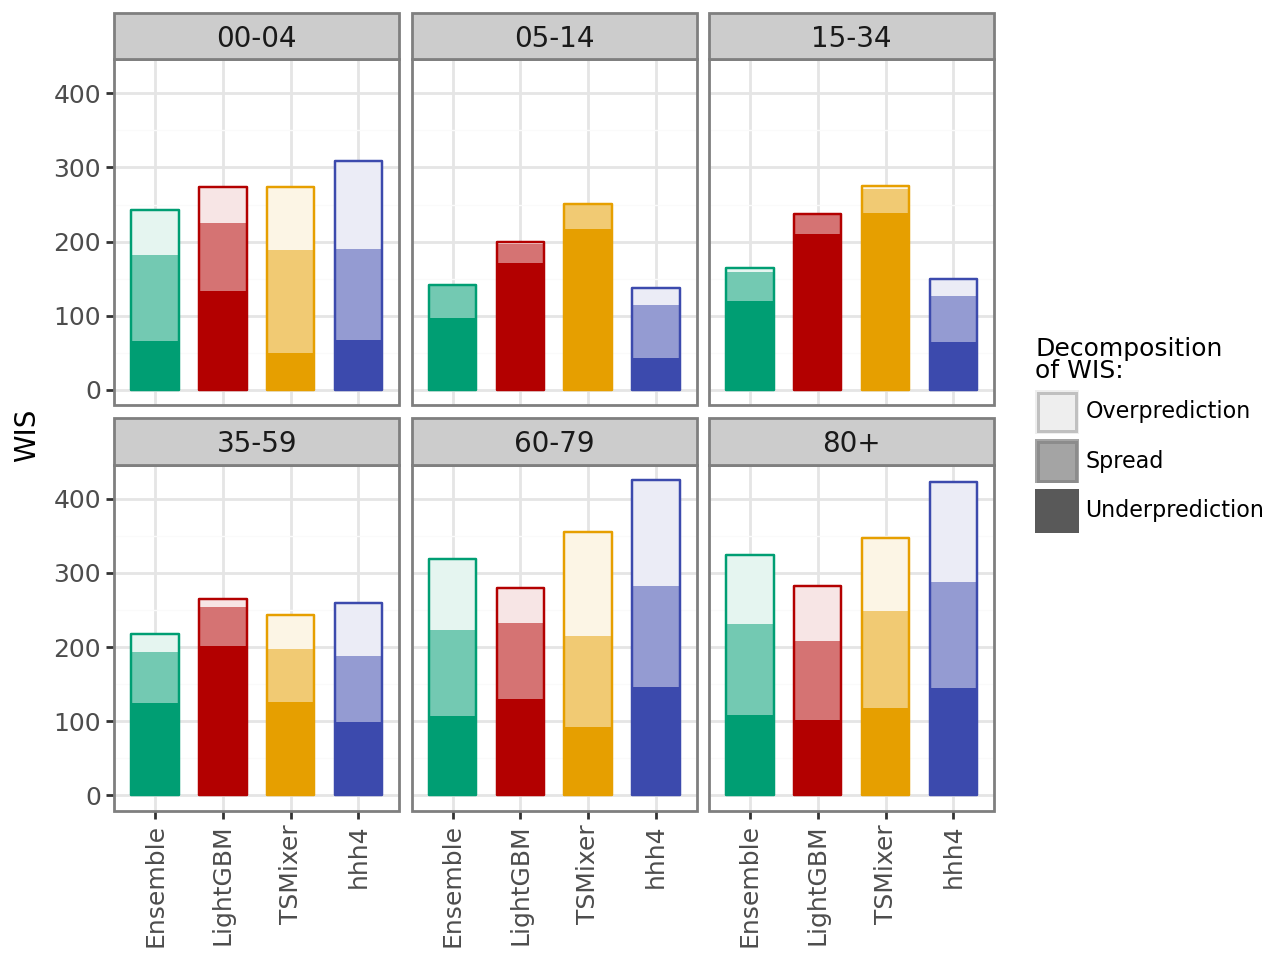

In [26]:
p = plot_scores_by_age_group(scores_age)
p

In [163]:
p.save("../figures/wis_age.pdf", width = 160, height = 110, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 110.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age.pdf
